# **MIT 6.5940 EfficientML.ai 2024 Fall: Lab 0 PyTorch Tutorial**

In this tutorial, we will explore how to train a neural network with PyTorch.

### Setup

We will first install a few packages that will be used in this tutorial:

In [2]:
!pip install torchprofile 1>/dev/null

We will then import a few libraries:

*   **`torch.optim.lr_scheduler` (Learning Rate Scheduler)**
    *   **用途**：這是 PyTorch 提供用來動態調整學習率 (Learning Rate) 的工具。在訓練神經網路時，通常不希望學習率從頭到尾都固定不變。例如，訓練初期可能需要較大的學習率來快速收斂，後期則減少學習率以進行微調。
    *   **在您的程式碼中**：使用了 `LambdaLR`。程式碼定義了一個 `lr_lambda` 函數，配合 `LambdaLR` 創建了一個「分段線性 (piecewise linear)」的排程器 (先從 0 升到 1，再降回 0)，用來控制每個 epoch 的學習率變化。

*   **`torchprofile`**
    *   **用途**：這是一個專門用來分析 PyTorch 模型運算量的第三方工具。它可以計算模型的 MACs (乘加運算次數) 或 FLOPs，這對於評估模型的「效率」非常重要。
    *   **在您的程式碼中**：使用了 `profile_macs` 函數 (`num_macs = profile_macs(model, ...)`) 來計算您的 VGG 模型在處理一張 32x32 圖片時需要多少運算量 (結果顯示約為 606M MACs)。這也是這門課 (EfficientML) 的重點之一。

*   **`torchvision`**
    *   **用途**：這是 PyTorch 官方的電腦視覺 (Computer Vision) 庫。它包含了常用的資料集 (Datasets)、模型架構 (Models) 和影像處理轉換工具 (Transforms)。
    *   **在您的程式碼中**：
        *   `torchvision.datasets`：用來下載並載入 CIFAR-10 資料集 (`CIFAR10(...)`)。
        *   `torchvision.transforms`：用來對圖片進行預處理和資料增強 (`RandomCrop`, `RandomHorizontalFlip`, `ToTensor`)，例如隨機裁切或翻轉圖片以增加訓練資料的多樣性。

*   **`tqdm.auto`**
    *   **用途**：這是一個進度條 (Progress Bar) 庫。它可以在迴圈執行時顯示一個動態的進度條，讓你即時看到訓練到了第幾步、預計剩餘時間以及目前的處理速度。`.auto` 表示它會自動偵測環境 (例如 Jupyter Notebook 或終端機) 來選擇最漂亮的顯示方式。
    *   **在您的程式碼中**：它包住了迴圈 `for inputs, targets in tqdm(dataflow, ...)`。這樣在執行 `train` 和 `evaluate` 函數時，您就能看到一個跑動的進度條，而不是枯燥的等待。

In [3]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

To ensure the reproducibility, we will control the seed of random generators:

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### Data

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [5]:
#針對train和test設定不同的圖片處理流程
# Compose用來將多個處理步驟串接起來，按順序執行
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),    # 隨機裁切，先補上padding(先變成40 X 40)，再隨機切一塊32 X 32下來
    RandomHorizontalFlip(),       # 隨機水平翻轉，預設 50% 的機率
    ToTensor(),                   # 1. 把圖片資料從 PIL Image 或 numpy 格式轉成 torch.Tensor (通道順序從 HWC 變 CHW)
                                  # 2. 將像素值從整數 [0, 255] 縮放到浮點數 [0.0, 1.0]。這是NN訓練的標準輸入格式
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",        # 要儲存的路徑
    train=(split == "train"),   # 當split == train時會載入50,000 張訓練圖片
    download=True,              # 如果 root 指定的資料夾裡沒有資料，程式會自動從網路上下載 CIFAR-10。如果有資料了就不會重複下載
    transform=transforms[split],# 將上面定義好的 transforms 套用到載入的圖片上
  )

100%|██████████| 170M/170M [00:03<00:00, 44.8MB/s] 


We can visualize a few images in the dataset and their corresponding class labels:

`image.permute`:PyTorch的格式是[C, H, W] (Channels, Height, Width)，例如這邊是`[3,32,32]`，常用的繪圖函式庫 `plt.imshow` 要求的圖片格式是 [H, W, C] (Height, Width, Channels)

1. permute 用來交換維度。 參數 (1, 2, 0) 的意思是：
    1. 新的第 0 維 = 原本的第 1 維 (Height)
    2. 新的第 1 維 = 原本的第 2 維 (Width)
    3. 新的第 2 維 = 原本的第 0 維 (Channels)

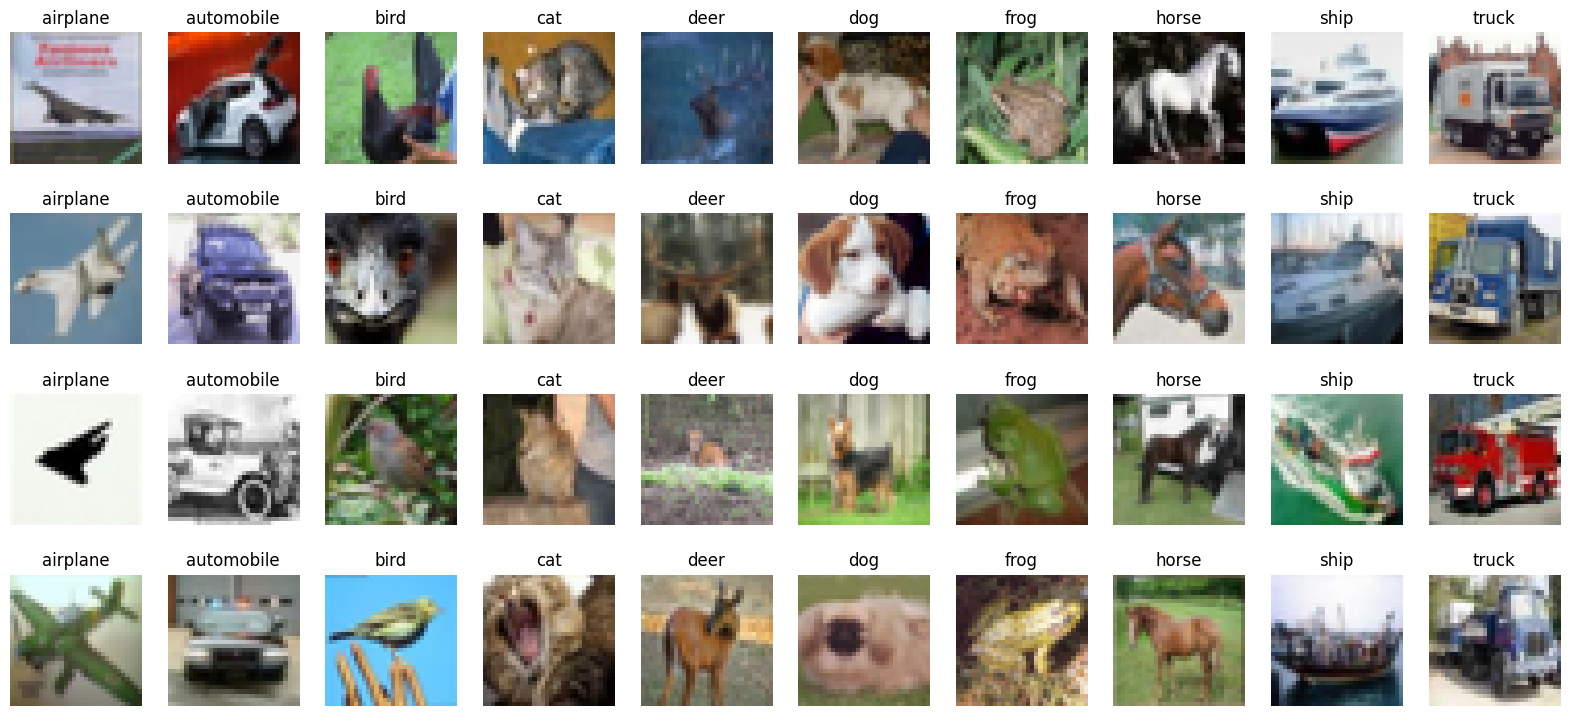

In [6]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]    # 將「數字標籤」轉回「人類看得懂的類別名稱」

  # Visualize the image
  plt.subplot(4, 10, index + 1)             # 切割畫布。這裡切成 4 列 10 行 (共40格)，並指定現在要畫在第幾格
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [7]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,               # batch size: 每次訓練或預測時，一次抓取多少張圖片
    shuffle=(split == 'train'),
    num_workers=0,                # 要用多少個 CPU 子程序 (Sub-processes) 預先讀取資料
    pin_memory=True,              # 這是一個加速技巧。它會把 CPU 的記憶體 (RAM) 鎖定 (Pin) 住，讓資料從 RAM 複製到 GPU (VRAM) 的速度變快
                                  # 只要用GPU訓練通常都建議把這個設為 True
  )

We can print the data type and shape from the training data loader:

In [8]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### Model

In this tutorial, we will use a variant of [VGG-11](https://arxiv.org/abs/1409.1556) (with fewer downsamples and a smaller classifier) as our model.

**VGG(Visual Geometry Group)**: 一種經典的卷積神經網路 (CNN)，它的特色是結構非常規整，由一堆 3x3 的卷積層堆疊而成

**ARCH (架構設定檔)**: 這是一個列表，用來設計模型的「藍圖」：

- 數字 (e.g., 64, 128)：代表該層卷積層 (Convolution Layer) 的 輸出通道數 (Output Channels)，也就是濾鏡 (Filter) 的數量。數字越大，代表模型能學到的特徵越豐富。
- 'M'：代表 最大池化層 (Max Pooling Layer)。它負責把圖片縮小一半 (下採樣)，讓運算量變少，同時擴大感受野

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:           # 用迴圈讀取上面的 ARCH，一層一層把積木堆起來
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))  # 負責提取圖片特徵
        add("bn", nn.BatchNorm2d(x))          # 用來穩定訓練，防止數值過大或過小，讓訓練速度變快
        add("relu", nn.ReLU(True))            # 引入非線性ReLU
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))          # 長寬各除以 2 (面積變 1/4)

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)      # 負責根據提取出的 512 個特徵，判斷這張圖是 10 個類別中的哪一個

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

model = VGG().cuda()    # 實例化模型，並立刻呼叫 .cuda() 把模型搬到 GPU 上
                        # 在 PyTorch 中，數據和模型都必須在同一個裝置 (GPU) 上才能運算，否則會報錯

Its backbone is composed of eight `conv-bn-relu` blocks interleaved with four `maxpool`'s to downsample the feature map by 2^4 = 16 times:

In [10]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

After the feature map is pooled, its classifier predicts the final output with a linear layer:

In [11]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


As this course focuses on efficiency, we will then inspect its model size and (theoretical) computation cost.


* The model size can be estimated by the number of trainable parameters:

In [12]:
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 9228362


* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):

In [ ]:
# params: model, inputs(假資料 / Dummy Input)[batch size, C, H, W]
# 然後因為model已經搬到GPU上了, data那邊也要搬到GPU上
# 下面就是測試 如果我丟進去一張 32x32 的彩色圖片，這個 VGG 模型需要做多少次加減乘除運算?
num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
print("#MACs:", num_macs)

#MACs: 606164480


This model has 9.2M parameters and requires 606M MACs for inference. We will work together in the next few labs to improve its efficiency.

### Optimization

As we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [14]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum):

In [ ]:
optimizer = SGD(
  model.parameters(),   # 這是告訴優化器：「更新這些參數」
  lr=0.4,
  momentum=0.9,         # 模擬物理學的「慣性」，0.9 代表這一步的方向有 90% 取決於之前的速度，10% 取決於當下的坡度
  weight_decay=5e-4,    # L2 Normalization
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

**One Cycle Policy**: 
- 前 30% 時間：LR 逐漸變大 (0 -> 0.4)。
- 後 70% 時間：LR 逐漸變小 (0.4 -> 0)。

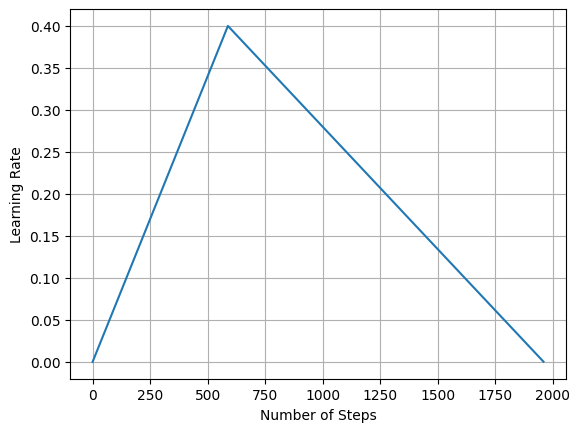

In [ ]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
# 定義lr如何變化，這邊用線性插值
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],  # X軸(時間): 0, num_epochs * 0.3: 訓練到 30% 的時候, num_epochs: 訓練結束
  [0, 1, 0]                           # Y 軸 (倍率): 從 0 開始，在 30% 的時候升到最高點 (100% 的 LR)，最後降回 0
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

# 把定義的lr跟optimizer綁定
scheduler = LambdaLR(optimizer, lr_lambda)  

### Training

We first define the training function that optimizes the model for one epoch (*i.e.*, a pass over the training set):

總結訓練迴圈口訣：
1. zero_grad (歸零)
2. forward (前向算 Loss)
3. backward (反向算梯度)
4. step (更新參數)

In [ ]:
# 無論模型多複雜，這 7 個步驟幾乎都是一模一樣的
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()   # 切換成train模式

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()   # PyTorch 的設計是累積梯度 (Accumulate Gradients)

    # Forward inference(算出預測結果)
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()   # 計算每一個參數對這次錯誤「貢獻」了多少 (計算梯度 / Gradient)
                      # 如果某個參數導致 Loss 變大，它的梯度就是正的；反之則是負的

    # Update optimizer and LR scheduler
    optimizer.step()  # 根據剛剛算出來的梯度，去更新模型裡面的參數 (權重)
    scheduler.step()  # 每做完一次更新，就微調一下現在的學習率 (Learning Rate)

We then define the evaluation function that calculates the metric (*i.e.*, accuracy in our case) on the test set:

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval()  #切換模式(eval會關閉Dropout, 鎖定BatchNorm)，記得要寫

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference (outputs 是一個長度為 10 的陣列 (Logits)，代表這張圖屬於 0~9 號類別的分數)
    outputs = model(inputs)

    # Convert logits to class indices
    # 這邊output是二維[batchsize, 10]，也就是圖片數量 X 種類
    # dim = 0(照row): 也就是比較同一column, dim = 1(照col): 也就是比較同一row
    # argmax(dim=1): 比較同一row中取最大值
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [19]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: 29.489999771118164


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: 44.470001220703125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: 57.65999984741211


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: 69.77999877929688


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: 67.9699935913086


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: 58.57999801635742


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: 75.4000015258789


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: 71.27000427246094


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: 61.439998626708984


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: 77.81999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: 57.650001525878906


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: 63.279998779296875


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: 80.35999298095703


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: 83.58000183105469


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: 81.81999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: 88.29000091552734


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: 89.61000061035156


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: 90.27000427246094


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: 91.67999267578125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 92.74999237060547


If everything goes well, your trained model should be able to achieve >92.5\% of accuracy!

### Visualization

We can visualize the model's prediction to see how the model truly performs:

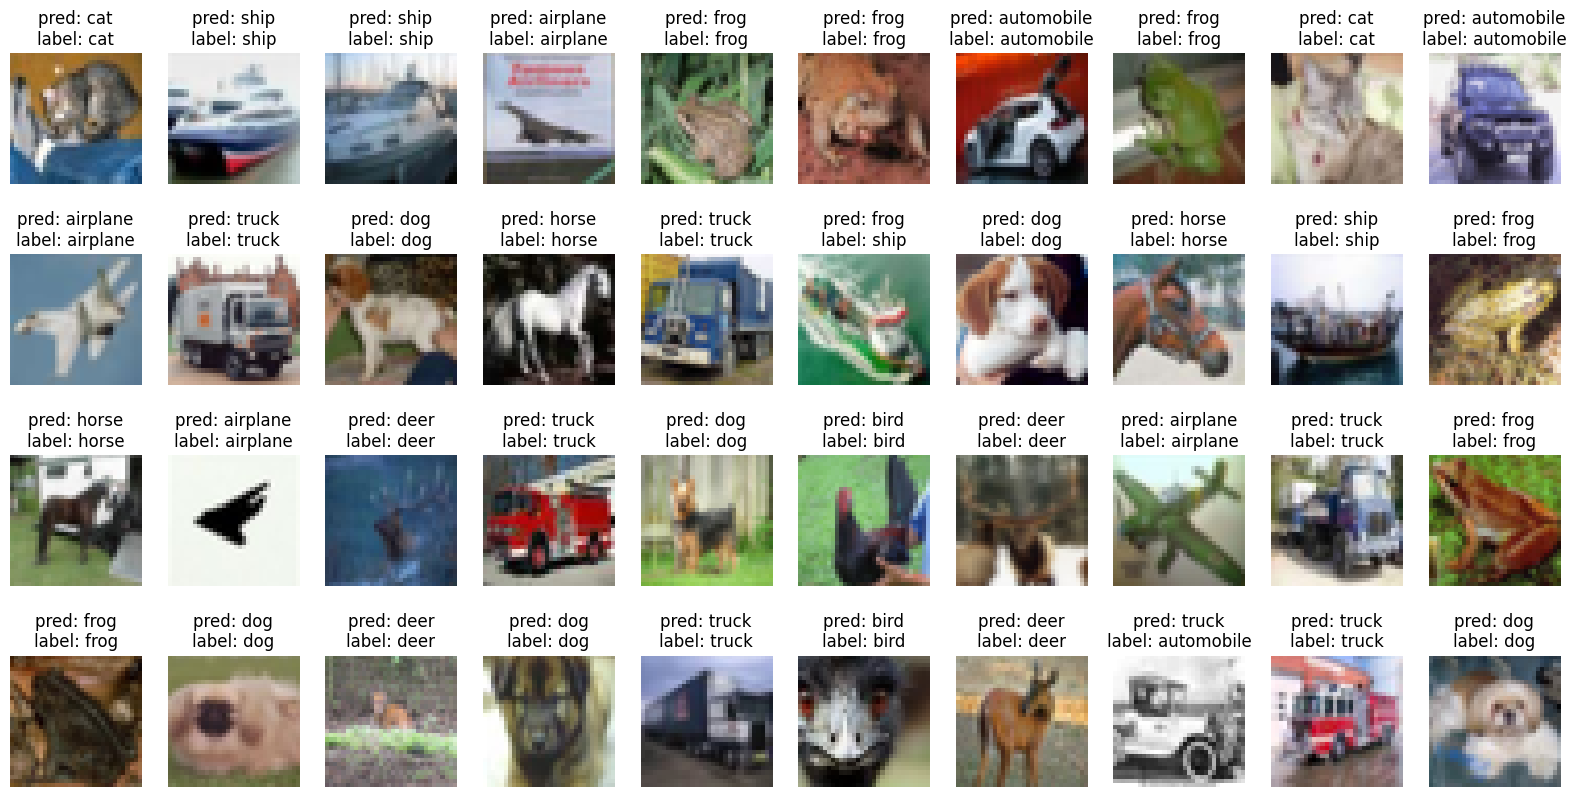

In [ ]:
plt.figure(figsize=(20, 10))
for index in range(40):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():  # 告訴 PyTorch 接下來不需要計算微分 (Gradient)，不需要做backprop
    pred = model(image.unsqueeze(dim=0).cuda()) #要取一張照片而訓練時預期輸入是(BS, C, H, W)
                                                # 那這邊unsqueeze(dim = 0)會在第0維增加一個維度
                                                # 變成batch形式，(1, C, H, W)
    pred = pred.argmax(dim=1)

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]      # 把預測的 ID (如 3) 轉成文字 (如 "cat")
  label = dataset["test"].classes[label]    # 把真實的 ID 轉成文字

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")                           # 關閉座標軸
plt.show()